### RL lunnar landing

Włączneie zdalnego ekranu

In [ ]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [12]:
import gymnasium

from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

### Tworzenie środowiska do uczenia modelu i spawdzenie tego co to srodowisko wraca.

In [25]:
import gymnasium as gym

# First, we create our environment called LunarLander-v2
env = gym.make("LunarLander-v2")

# Then we reset this environment
observation, info = env.reset()

for _ in range(20):
  # Take a random action
  action = env.action_space.sample()
  print("Action taken:", action)

  # Do this action in the environment and get
  # next_state, reward, terminated, truncated and info
  observation, reward, terminated, truncated, info = env.step(action)

  # If the game is terminated (in our case we land, crashed) or truncated (timeout)
  if terminated or truncated:
      # Reset the environment
      print("Environment is reset")
      observation, info = env.reset()

env.close()

Action taken: 2
Action taken: 3
Action taken: 3
Action taken: 0
Action taken: 1
Action taken: 0
Action taken: 3
Action taken: 2
Action taken: 3
Action taken: 1
Action taken: 2
Action taken: 3
Action taken: 2
Action taken: 1
Action taken: 1
Action taken: 3
Action taken: 0
Action taken: 0
Action taken: 3
Action taken: 1


In [14]:
# We create our environment with gym.make("<name_of_the_environment>")
env = gym.make("LunarLander-v2")
env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env.observation_space.shape)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Shape (8,)
Sample observation [-67.32044   -48.400967   -1.0671839   1.8047749  -1.7064798  -3.2733867
   0.6526308   0.9867231]


In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) 


 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 1


In [16]:
# Create the environment
env = make_vec_env('LunarLander-v2', n_envs=16)

In [17]:
# SOLUTION
# We added some parameters to accelerate the training
model = PPO(
    policy = 'MlpPolicy',
    env = env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1)

Using cuda device


In [ ]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm

# Create a custom callback to show tqdm and ep_rew_mean
class ProgressBarCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(ProgressBarCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.progress_bar = None
        self.total_timesteps = 0  # Initialize total_timesteps here
        
    def _on_training_start(self):
        # Store total_timesteps for the progress bar
        self.total_timesteps = self.locals["total_timesteps"]
        self.progress_bar = tqdm(total=self.total_timesteps, desc="Training Progress")
        
    def _on_step(self) -> bool:
        # Update progress bar after each step
        if self.progress_bar:
            self.progress_bar.update(self.model.n_steps)
        
        return True

    def _on_rollout_end(self):
        # After each rollout, print the mean reward
        mean_reward = np.mean(self.episode_rewards) if len(self.episode_rewards) > 0 else -np.inf
        self.progress_bar.set_postfix(ep_rew_mean=mean_reward)
        
    def _on_training_end(self):
        if self.progress_bar:
            self.progress_bar.close()


callback = ProgressBarCallback()

model.learn(total_timesteps=1000000, callback=callback)

model_name = "ppo-LunarLander-v2"
model.save(model_name)


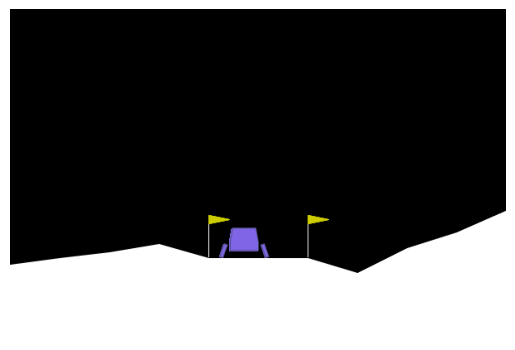

In [22]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

env = gym.make("LunarLander-v2", render_mode='rgb_array')
obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.05)
env.close()
